# Twitter US Airline Sentiment
## Data Description: 
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

### 1. Import the libraries, load dataset, print shape of data, data description

In [2]:
# install and import necessary libraries.
!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

     |████████████████████████████████| 317kB 7.0MB/s 
     |████████████████████████████████| 245kB 30.8MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81700 sha256=8b447833b1dcc4f82b27bb25f21b96da83c73fefdb93f487ba40f595b7c20c50
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
# Loading dataset into pandas dataframe
from google.colab import drive
drive.mount("/content/drive")
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NLP/Exam/Tweets.csv")

Mounted at /content/drive


In [4]:
# Shape of data
data.shape

(14640, 15)

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# data description
data.describe(percentiles=[.25,.5,.75,.90,.95,.99]).transpose()

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.700986e+17,5.702563e+17,5.702987e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.400000e+01


In [7]:
# data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

### 2. Understand of data-columns:

In [8]:
# a. Drop all other columns except "text" and "airline_sentiment"
data = data.loc[:, ['text', 'airline_sentiment']]

In [9]:
# b. Check the shape of data
data.shape

(14640, 2)

In [10]:
# c. Print first 5 rows of data
pd.set_option('display.max_colwidth', None)
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\r\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


### 3. Text pre-processing: Data preperation

In [11]:
# a. Html tag removal
def strip_html(text):
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

data['text'] = data['text'].apply(lambda x: strip_html(x))
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\r\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there.",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


In [12]:
# c. Remove the numbers
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head(10)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials to the experience... tacky.,positive
2,@VirginAmerica I didn't today... Must mean I need to take another trip!,neutral
3,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse",negative
4,@VirginAmerica and it's a really big bad thing about it,negative
5,@VirginAmerica seriously would pay $ a flight for seats that didn't have this playing.\r\nit's really the only bad thing about flying VA,negative
6,"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",positive
7,"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there.",neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",positive
9,"@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.",positive


In [13]:
# d. Removal of Special Characters and Punctuations
def remove_special_characters(text):
  text = re.sub(r"(@\S+)", "", text) # remove hashtags
  text = re.sub(r'\W', ' ', str(text)) # remove all special characters including apastrophie 
  text = text.translate(str.maketrans('', '', string.punctuation)) # remove punctuations 
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)   # remove all single characters (it's -> it s then we need to remove s)
  text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
  return text

data['text'] = data['text'].apply(lambda x: remove_special_characters(x))
data.head(10)

,text,airline_sentiment
0,What said,neutral
1,plus you ve added commercials to the experience tacky,positive
2,didn today Must mean need to take another trip,neutral
3,it really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,negative
4,and it a really big bad thing about it,negative
5,seriously would pay flight for seats that didn have this playing it really the only bad thing about flying VA,negative
6,yes nearly every time fly VX this ear worm won go away,positive
7,Really missed prime opportunity for Men Without Hats parody there,neutral
8,Well didn but NOW DO D,positive
9,it was amazing and arrived an hour early You re too good to me,positive


In [14]:
# e. Conversion to lowercase
def convert_lower_case(text):
  text = text.lower()
  return text

data['text'] = data['text'].apply(lambda x: convert_lower_case(x))
data.head(10)

,text,airline_sentiment
0,what said,neutral
1,plus you ve added commercials to the experience tacky,positive
2,didn today must mean need to take another trip,neutral
3,it really aggressive to blast obnoxious entertainment in your guests faces they have little recourse,negative
4,and it a really big bad thing about it,negative
5,seriously would pay flight for seats that didn have this playing it really the only bad thing about flying va,negative
6,yes nearly every time fly vx this ear worm won go away,positive
7,really missed prime opportunity for men without hats parody there,neutral
8,well didn but now do d,positive
9,it was amazing and arrived an hour early you re too good to me,positive


In [15]:
# b. Tokenization (used word tokenization, tweet tokenization could also be used)
data['text'] = data.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
data.head(10)

,text,airline_sentiment
0,"[what, said]",neutral
1,"[plus, you, ve, added, commercials, to, the, experience, tacky]",positive
2,"[didn, today, must, mean, need, to, take, another, trip]",neutral
3,"[it, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]",negative
4,"[and, it, a, really, big, bad, thing, about, it]",negative
5,"[seriously, would, pay, flight, for, seats, that, didn, have, this, playing, it, really, the, only, bad, thing, about, flying, va]",negative
6,"[yes, nearly, every, time, fly, vx, this, ear, worm, won, go, away]",positive
7,"[really, missed, prime, opportunity, for, men, without, hats, parody, there]",neutral
8,"[well, didn, but, now, do, d]",positive
9,"[it, was, amazing, and, arrived, an, hour, early, you, re, too, good, to, me]",positive


In [16]:
# I think it is important to remove the stop words (High frequent words) to remove the bias of most commonly occuring words and which do not have any impact on the model
# Excluding certain set of stopwords, which play key role for our model. Some stop-word's have significance in construction of sentiment analysis model. So they are not removed from original data.
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

stopwords = list(set(stopwords) - set(customlist))  

In [17]:
# f. Lemmatize is chosen instead of stemming
lemmatizer = WordNetLemmatizer()

# stop words to improve the model prediction accuracy
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

# g. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format)
def normalize(words):
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

data['text'] = data.apply(lambda row: normalize(row['text']), axis=1)

# h. Print first 5 rows of data after preprocessing
data.head(5)

,text,airline_sentiment
0,say,neutral
1,plus add commercials experience tacky,positive
2,didn today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainment guests face little recourse,negative
4,really big bad thing,negative


### 4. Vectorization

In [18]:
# a. Use CountVectorizer (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=500)                # Keep only 1000 features as number of features will increase the processing time.
data_features = vectorizer.fit_transform(data['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

print(data_features.shape)
pd.DataFrame(data_features, columns = vectorizer.get_feature_names())

(14640, 500)


,aa,able,account,actually,add,address,agent,agents,ago,air,airline,airlines,airport,airways,allow,almost,already,also,always,amaze,american,another,answer,anyone,anything,apology,app,appreciate,around,arrive,ask,assistance,attendant,attendants,available,award,away,awesome,awful,back,...,us,usair,usairways,use,vacation,vegas,via,voucher,wait,want,wasn,waste,watch,way,weather,website,week,weeks,well,wife,wifi,win,wish,without,word,work,world,worry,worse,worst,would,wouldn,wow,wrong,yeah,year,years,yes,yesterday,yet
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# b.Use TfidfVectorizer (convert text data to numbers)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
data_features = vectorizer.fit_transform(data['text'])

data_features = data_features.toarray()

data_features.shape
pd.DataFrame(data_features, columns = vectorizer.get_feature_names())

,aa,able,absolute,absolutely,accept,acceptable,access,accommodate,account,act,actual,actually,add,additional,address,advise,advisory,afternoon,agent,agents,ago,air,aircraft,airline,airlines,airplane,airport,airports,airways,alert,allow,almost,alone,along,already,also,always,amaze,america,american,...,week,weekend,weeks,welcome,well,weren,whole,wife,wifi,will,win,window,winter,wish,without,wonder,wonderful,word,work,world,worry,worse,worst,worth,would,wouldn,wow,write,wrong,wtf,yall,yeah,year,years,yep,yes,yesterday,yet,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.571056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.490547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 5. Fit and evaluate model using both type of vectorization

In [20]:
# Label encoding
from sklearn.preprocessing import LabelEncoder

labels = data['airline_sentiment']
le = LabelEncoder()
label = le.fit_transform(labels)

In [21]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_features, label, test_size=0.3, random_state=42)

In [22]:
# Using Random Forest to build model for sentiment analysis.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7434426229508196


In [23]:
# Predict the result for test data using the model built above.
result = forest.predict(X_test)

[[2559  189   66]
 [ 390  426   68]
 [ 210   89  395]]


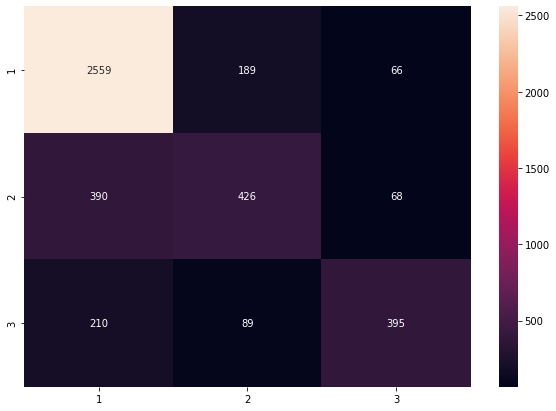

In [24]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [25]:
# Using Random Forest to build model for sentiment analysis.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

import numpy as np

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, data_features, labels, cv=10)))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)
0.7417349726775957


In [26]:
result = forest.predict(X_test)

[[2552  173   89]
 [ 407  405   72]
 [ 209   79  406]]


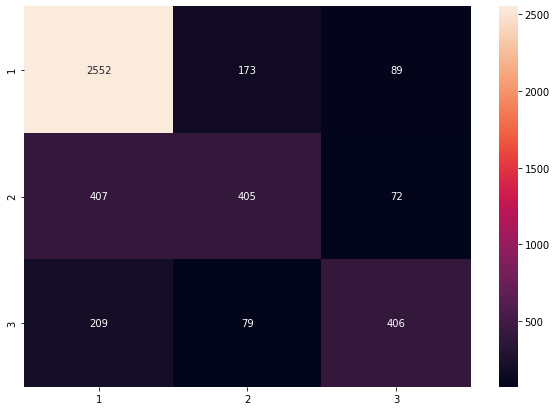

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "123"],
                  columns = [i for i in "123"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### 6. Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset

- The dataset consists of tweets in text format and the sentiments are rated as positive, negative and neutral.
- The goal was to build a model for sentiment analysis.
- The tweets are preprocessed using variuos techniques such as HTML tag removal, tokenization, conversion of lowercase, lemmetization etc. and libraries.
- The pre-precessed data is converted to numbers using count vectorization and TF-IDF methods, so that we can feed the data into the model.
- After building the Random forests classification model, the results are predicted for the test data.
- The model performance is using the above techniques is good in perspective of how the text classification models perform.
- The model accuracy of can be improved by increasing the dataset we took into account for the model building (Here we have only limited amount of  data, i.e. 14640 entries, which may be is less compared to the number of dimensions (500) we have in our model)
- One more way to increase accuracy is to use different variations of Pre-processing techniques such as tweet tokenization, stop words etc.
- The accuracy results for the classification models created based on TF-IDF and count vectorizer are almost the same with no much of difference.